In [1]:
# Positional evaluation analysis notebook
# 'Start' experiments
# Hans Verdolaga
# MSc Mechatronics 2023
# MC-F23 Thesis

In [2]:
# -----------------------------------------------------------------------------
# Libraries
# -----------------------------------------------------------------------------
# Import user libraries
import apriltag_config as cfg

# Import system libraries 
import os
import sys
import time
import ast

import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import copy

%matplotlib inline

In [3]:
# -----------------------------------------------------------------------------
# High level information
# -----------------------------------------------------------------------------
runName = 'filtering_simple_1'#'auto_baseline_test'#'filtering_simple_1'
warmupTime = 20 # seconds

In [4]:
# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------

In [5]:
# -----------------------------------------------------------------------------
# Data loading
# -----------------------------------------------------------------------------
# Load data
parentFolder = os.path.abspath("") + '/'
hostFolder = parentFolder + 'host_results/'

# Initialize position list for saving dictionaries
positionList = []

# Load 'start' results
dateFolder = hostFolder + '20230511_results/'#'20233004_results/'#'20230511_results/'
resultsFile = dateFolder + 'results.csv'
results = pd.read_csv(resultsFile)

# Filter results by specified name
resultsFiltered = results[results['experimentName'].str.startswith(runName)]
# Enumerate outcome column
    # 0 - failure or aborted
    # 1 - success
resultsFiltered['outcome'] = resultsFiltered['outcome'].apply(lambda x: 1 if x == 'success' else 0)

# Get only the latest entry of duplicate experiment names
resultsFiltered = resultsFiltered.drop_duplicates(subset=['experimentName'], keep='last')

# Convert non-nan lastCoord entries
resultsFiltered['lastCoord'] = resultsFiltered['lastCoord'].apply(lambda x: ast.literal_eval(x) if type(x) == str else x)

# Add columns for position and iteration
# resultsFiltered['position'] = resultsFiltered['experimentName'].apply(lambda x: x.split('_')[-2])
resultsFiltered['position'] = resultsFiltered['experimentName'].apply(lambda x: int(''.join(filter(str.isdigit, x.split('_')[-2]))))
resultsFiltered['iteration'] = resultsFiltered['experimentName'].apply(lambda x: int(''.join(filter(str.isdigit, x.split('_')[-1]))))

# Loop through all data files based on experiment name and append to dataframe column
logFolder = dateFolder + 'logs/'
logFiles = os.listdir(logFolder)

# Remove dataframe rows that have no csv log file
for name in resultsFiltered['experimentName']:
    if not any(name in s for s in logFiles):
        resultsFiltered = resultsFiltered[resultsFiltered['experimentName'] != name]

# Prepare new columns for data entry
# New columns with dtype as object
resultsFiltered['logTime'] = None
resultsFiltered['logCoord'] = None
resultsFiltered['logHeading'] = None
resultsFiltered['logHeadingRelative'] = None
resultsFiltered['distanceTravelled'] = 0

resultsFiltered['logTime'] = resultsFiltered['logTime'].astype(object)
resultsFiltered['logCoord'] = resultsFiltered['logCoord'].astype(object)
resultsFiltered['logHeading'] = resultsFiltered['logHeading'].astype(object)
resultsFiltered['logHeadingRelative'] = resultsFiltered['logHeadingRelative'].astype(object)

# Real source coordinates
realSourceCoord = np.array(cfg.sourceRealTrueCoords)

# print(resultsFiltered)
for logFile in logFiles:
    if logFile.startswith(runName):
        logFileName = logFile.split('.')[0]
        logFile = logFolder + logFile

        logData = pd.read_csv(logFile)

        # Remove all zero times except for last
        logData = logData.drop(logData[logData['timeStamp'] < warmupTime].index[:-1]) # Drop all times before warmup

        # Add time series to logTime column
        # Index of row where experiment name matches
        experimentNameIndex = resultsFiltered[resultsFiltered['experimentName'] == logFileName].index[0]
        
        # Add time series to logTime column
        resultsFiltered.at[experimentNameIndex, 'logTime'] = logData['timeStamp'].values
        # Add coord series to logCoord column
        # resultsFiltered.at[experimentNameIndex, 'logCoord'] = logData['robotRealCenCoords'].values
        resultsFiltered.at[experimentNameIndex, 'logCoord'] = [
            (np.fromstring(x.replace("[nan nan]", "(nan,nan)").strip("()"), sep=',')) 
            for x in logData['robotRealCenCoords'].values
        ]

        # Add heading series to logHeading column
        resultsFiltered.at[experimentNameIndex, 'logHeading'] = logData['robotHeading'].values

        # Replace lastCoord and lastHeading if nan with last known value from log
        if np.isnan(resultsFiltered.at[experimentNameIndex,'lastHeading']):
            lastCoordIdx = [num for num,x in enumerate(
                resultsFiltered.at[experimentNameIndex, 'logCoord']) 
                if not np.isnan(x).any()][-1]
            resultsFiltered.at[experimentNameIndex, 'lastCoord'] = tuple(resultsFiltered.at[
                experimentNameIndex, 'logCoord'][lastCoordIdx])

            lastHeadingIdx = pd.DataFrame(resultsFiltered.at[
                experimentNameIndex, 'logHeading']).apply(pd.Series.last_valid_index)
            resultsFiltered.at[experimentNameIndex, 'lastHeading'] = resultsFiltered.at[
                experimentNameIndex, 'logHeading'][lastHeadingIdx]

        # Use logCoords to calculate total distance travelled
        for i in range(len(resultsFiltered.at[experimentNameIndex, 'logCoord']) - 1):
            # print(resultsFiltered.at[experimentNameIndex, 'logCoord'][i])
            # print(resultsFiltered.at[experimentNameIndex, 'logCoord'][i+1])
            # print(np.linalg.norm(np.array(resultsFiltered.at[experimentNameIndex, 'logCoord'][i]) - np.array(resultsFiltered.at[experimentNameIndex, 'logCoord'][i+1])))
            temp = np.linalg.norm(np.array(resultsFiltered.at[experimentNameIndex, 'logCoord'][i]) - np.array(resultsFiltered.at[experimentNameIndex, 'logCoord'][i+1]))
            if not np.isnan(temp):
                resultsFiltered.at[experimentNameIndex, 'distanceTravelled'] += abs(temp)


        # Add relative heading series to logHeadingRelative column
        angleSeries = []
        for i in range(len(resultsFiltered.at[experimentNameIndex, 'logCoord'])):
            # Compute angle from horizontal (x-axis)
            angleSeries.append(resultsFiltered.at[experimentNameIndex, 'logHeading'][i] + np.arctan2(
                realSourceCoord[1] - resultsFiltered.at[experimentNameIndex, 'logCoord'][i][1],
                realSourceCoord[0] - resultsFiltered.at[experimentNameIndex, 'logCoord'][i][0]
            ) * 180 / np.pi )
        # print(angleSeries)
        resultsFiltered.at[experimentNameIndex, 'logHeadingRelative'] = angleSeries
        
# Sort by position and iteration
resultsFiltered = resultsFiltered.sort_values(by=['position', 'iteration'])

# Remove all rows with invalid positions (nan or greater than 8)
resultsFiltered = resultsFiltered.drop(resultsFiltered[resultsFiltered['position'] > 8].index)
resultsFiltered = resultsFiltered.drop(resultsFiltered[resultsFiltered['position'].isnull()].index)
        

C:\Users\hansv\AppData\Local\Temp\ipykernel_11132\761863758.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultsFiltered['outcome'] = resultsFiltered['outcome'].apply(lambda x: 1 if x == 'success' else 0)


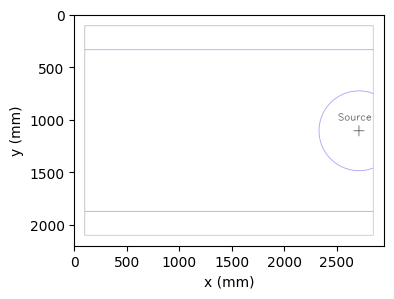

In [6]:
# -----------------------------------------------------------------------------
# Layout generation
# -----------------------------------------------------------------------------
# Draw layout with openCV
# Initialize canvas
padV = 100
padH = 100
padArr = np.array([padH, padV])

width = 2750
height = 2000
canvas = np.ones((height, width, 3), dtype=np.uint8)*255

# plt.imshow(canvas)
# plt.axis('off')

# Draw topdown rectangle with width and height
cv.rectangle(canvas, (0,0), (width, height), 
             cfg.topDownBorderColour, 8)

# Draw source cross
cv.drawMarker(canvas, (np.array(cfg.sourceRealTrueCoords)).astype(np.uint16), (0,0,0), 
              markerType=cv.MARKER_CROSS, markerSize=100, thickness=4)

# Draw source saftey radius
cv.circle(canvas, (np.array(cfg.sourceRealTrueCoords)).astype(np.uint16),
            cfg.sourceSafetyDistance, cfg.topDownSafetyColour, 4, cv.LINE_AA, 0)

# Draw horizontal safety boundaries
topLeftSafetyCoords = [0, cfg.sideSafetyDistance]
bottomLeftSafetyCoords = [0, height - cfg.sideSafetyDistance]
bottomRightSafetyCoords = [width, height - cfg.sideSafetyDistance]
topRightSafetyCoords = [width, cfg.sideSafetyDistance]

# Draw top line
cv.line(canvas, topLeftSafetyCoords, topRightSafetyCoords,
        cfg.topDownSafetyColour, 3)

# Draw bottom line
cv.line(canvas, bottomLeftSafetyCoords, bottomRightSafetyCoords,
        cfg.topDownSafetyColour, 3)

# Label source
cv.putText(canvas, "Source", [int(cfg.sourceRealTrueCoords[0]-200), 
                                int(cfg.sourceRealTrueCoords[1])-100], 
                cv.FONT_HERSHEY_SIMPLEX, 3, cfg.topDownSourceColour, 3)

# IMAGE PREVIEW
# Pad array with white border
preview = np.pad(canvas, ((padV, padV), (padH, padH), (0,0)), mode='constant', constant_values=255)

# # Preview canvas with border and no axis
plt.figure(figsize=(4,3))

# Set axis labels
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

plt.imshow(preview)
# # plt.axis('off')


In [7]:
# Create new column in dataframe for spaced coordinates and headings
resultsFiltered['spacedCoord'] = None
resultsFiltered['spacedHeading'] = None
resultsFiltered['spacedHeadingRelative'] = None
resultsFiltered['spacedCoord'] = resultsFiltered['spacedCoord'].astype(object)
resultsFiltered['spacedHeading'] = resultsFiltered['spacedHeading'].astype(object)
resultsFiltered['spacedHeadingRelative'] = resultsFiltered['spacedHeadingRelative'].astype(object)

# Loop over time column and append to spacedCoord column as list every 1 second
for index, row in resultsFiltered.iterrows():
    # Get time series
    # print(row)
    timeSeries = row['logTime']
    coordSeries = row['logCoord']
    headingSeries = row['logHeading']
    headingRelativeSeries = row['logHeadingRelative']

    # Initialize spacedCoord list
    spacedCoord = []
    spacedHeading = []
    spacedHeadingRelative = []

    i = 0
    while i < len(timeSeries):
        if np.isnan(coordSeries[i]).any():
            i+=1 # Traverse until non-nan value
        else:
            spacedCoord.append(coordSeries[i])
            spacedHeading.append(headingSeries[i])
            spacedHeadingRelative.append(headingRelativeSeries[i])
            i+=10

    # Append spacedCoord list to dataframe
    resultsFiltered.at[index, 'spacedCoord'] = spacedCoord
    resultsFiltered.at[index, 'spacedHeading'] = spacedHeading
    resultsFiltered.at[index, 'spacedHeadingRelative'] = spacedHeadingRelative

In [133]:
# -----------------------------------------------------------------------------
# Map generator
# -----------------------------------------------------------------------------
def generateMap(
        image: np.ndarray, dataframe: pd.DataFrame, 
        position: int = None, iteration: int = None,
        successOnly = False
):
    # Copy canvas to new image
    generatedMap = copy.deepcopy(image)

    # Copy dataframe based on selected position, iteration or both
    if position is not None and iteration is not None:
        dataframe = dataframe[(dataframe['position'] == position) & (dataframe['iteration'] == iteration)]
    elif position is not None:
        dataframe = dataframe[dataframe['position'] == position]
    elif iteration is not None:
        dataframe = dataframe[dataframe['iteration'] == iteration]
    else:
        dataframe = dataframe

    # Draw pathlines for all rows in dataframe
    for index, row in dataframe.iterrows():
        # Get spacedCoord list
        spacedCoordList = row['spacedCoord']
        spacedHeadingList = row['spacedHeading']

        # Draw spaced positions and headings on canvas
        for i in range(len(spacedCoordList)):
            # Draw robot circle
            if row['outcome'] == 1:
                cv.circle(generatedMap, (np.array(spacedCoordList[i])).astype(np.int16),
                            10, (0,120,0), 4, cv.LINE_AA, 0)
            elif not successOnly:
                cv.circle(generatedMap, (np.array(spacedCoordList[i])).astype(np.int16),
                            10, (155,155,155), 2, cv.LINE_AA, 0)
            
            # Draw robot heading
            coord1 = (np.array(spacedCoordList[i])).astype(np.int16)
            coord2 = ((np.array(spacedCoordList[i])).astype(np.int16) + 
                    (np.array([np.cos(spacedHeadingList[i] * -np.pi/180),
                                np.sin(spacedHeadingList[i] * -np.pi/180)])*100).astype(np.int16))
            
            if row['outcome'] == 1:
                cv.line(generatedMap, coord1, coord2, (0,120,0), 4, cv.LINE_AA, 0)
            elif not successOnly:
                cv.line(generatedMap, coord1, coord2, (225,225,225), 2, cv.LINE_AA, 0)

        # Mark last coordinate based on outcome
        if row['outcome'] == 1:
            cv.drawMarker(generatedMap, (np.array(row['lastCoord'])).astype(np.int16), (0,120,0), 
                        markerType=cv.MARKER_DIAMOND, markerSize=100, thickness=8)
        elif not successOnly:
            cv.drawMarker(generatedMap, (np.array(row['lastCoord'])).astype(np.int16), (180,0,0), 
                        markerType=cv.MARKER_DIAMOND, markerSize=100, thickness=8)

    # Return padded image
    return np.pad(generatedMap, ((padV, padV), (padH, padH), (0,0)), mode='constant', constant_values=255)

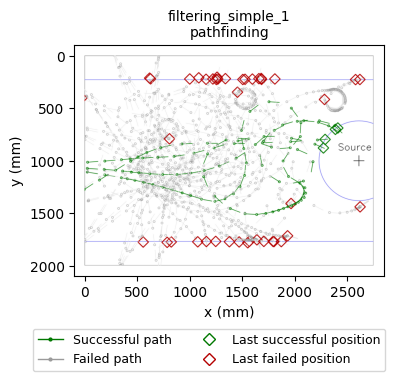

In [144]:
# Trajectory diagram (ACTUAL)
specific = generateMap(canvas, resultsFiltered, position=None, iteration=None, successOnly=False)
# # Preview canvas with border and no axis
plt.figure(figsize=(4,3))

# Add title with experiment name
plt.title(f'{runName}\npathfinding', fontsize=10)

# Set ticks starting from 100
plt.xticks(np.arange(100, 2950, 500), ['0', '500', '1000', '1500', '2000', '2500'])
plt.yticks(np.arange(100, 2200, 500), ['0', '500', '1000', '1500', '2000'])

# Set axis labels
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# Custom legend
custom_lines = [Line2D([0], [0], marker='o', color=np.array([0,120,0])/255, lw=1, markersize=2),
                Line2D([0], [0], marker='o', color=np.array([155,155,155])/255, lw=1, markersize=2),
                Line2D([0], [0], marker='D', color=np.array([0,120,0])/255, markerfacecolor='w', lw=0),
                Line2D([0], [0], marker='D', color=np.array([180,0,0])/255, markerfacecolor='w', lw=0)]
plt.legend(custom_lines, ['Successful path', 'Failed path', 
                          'Last successful position', 'Last failed position'], 
                          loc='upper left', bbox_to_anchor=(-0.155, -0.2), 
                          ncol=2, fontsize=9)

# Scale canvas to square grid
plt.imshow(specific)

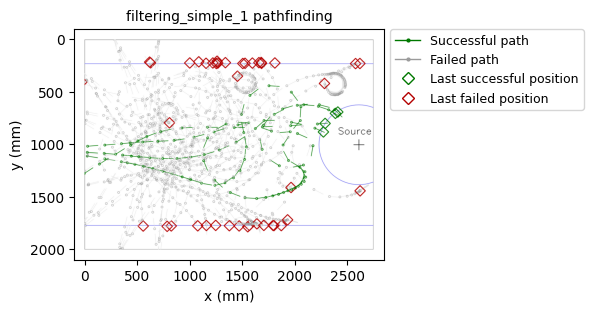

In [145]:
# Trajectory diagram (EXAMPLE)
specific = generateMap(canvas, resultsFiltered, position=None, 
                       iteration=None, successOnly=False)
# # Preview canvas with border and no axis
plt.figure(figsize=(4,3))

# Add title with experiment name
plt.title(f'{runName} pathfinding', fontsize=10)

# Set ticks starting from 100
plt.xticks(np.arange(100, 2950, 500), ['0', '500', '1000', '1500', '2000', '2500'])
plt.yticks(np.arange(100, 2200, 500), ['0', '500', '1000', '1500', '2000'])

# Set axis labels
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# Custom legend
custom_lines = [Line2D([0], [0], marker='o', color=np.array([0,120,0])/255, 
                       lw=1, markersize=2),
                Line2D([0], [0], marker='o', color=np.array([155,155,155])/255, 
                       lw=1, markersize=2),
                Line2D([0], [0], marker='D', color=np.array([0,120,0])/255, 
                       markerfacecolor='w', lw=0),
                Line2D([0], [0], marker='D', color=np.array([180,0,0])/255, 
                       markerfacecolor='w', lw=0)]
plt.legend(custom_lines, ['Successful path', 'Failed path', 
                          'Last successful position', 'Last failed position'], 
                          loc='upper left', bbox_to_anchor=(1,1.025), 
                          ncol=1, fontsize=9)

# Scale canvas to square grid
plt.imshow(specific)

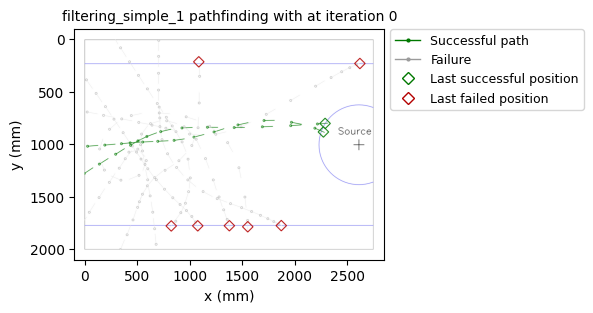

In [149]:
# Specific examples
specific = generateMap(canvas, resultsFiltered, position=None, 
                       iteration=0, successOnly=None)
# # Preview canvas with border and no axis
plt.figure(figsize=(4,3))

# Add title with experiment name
plt.title(f'{runName} pathfinding with at iteration 0', fontsize=10)

# Set ticks starting from 100
plt.xticks(np.arange(100, 2950, 500), ['0', '500', '1000', '1500', '2000', '2500'])
plt.yticks(np.arange(100, 2200, 500), ['0', '500', '1000', '1500', '2000'])

# Set axis labels
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# Custom legend
custom_lines = [Line2D([0], [0], marker='o', color=np.array([0,120,0])/255, 
                       lw=1, markersize=2),
                Line2D([0], [0], marker='o', color=np.array([155,155,155])/255, 
                       lw=1, markersize=2),
                Line2D([0], [0], marker='D', color=np.array([0,120,0])/255, 
                       markerfacecolor='w', lw=0),
                Line2D([0], [0], marker='D', color=np.array([180,0,0])/255, 
                       markerfacecolor='w', lw=0)]
plt.legend(custom_lines, ['Successful path', 'Failure', 
                          'Last successful position', 'Last failed position'], 
                          loc='upper left', bbox_to_anchor=(1,1.025), 
                          ncol=1, fontsize=9)

# Scale canvas to square grid
plt.imshow(specific)

In [11]:
# Add column to calculate trajectory directness length and heading
resultsFiltered['directness'] = None

# Loop over dataframe and calculate directness polar metrics
for index, row in resultsFiltered.iterrows():
    # Get spacedCoord and spacedHeading lists
    spacedCoordList = row['spacedCoord']
    #spacedHeadingList = row['spacedHeading']
    spacedHeadingRelativeList = row['spacedHeadingRelative']

    # Initialize lists
    lengthList = []
    radiusList = []
    angleList = []

    # Calculate directness radius and angle
    for i in range(len(spacedCoordList)):
        if i == 0:
            lengthList.append(0)
            radiusList.append(0)
            angleList.append(0)
        else:
            lengthList.append(np.linalg.norm(spacedCoordList[i] - spacedCoordList[i-1]))
            radiusList.append(np.linalg.norm(spacedCoordList[i] - spacedCoordList[i-1])*np.cos(spacedHeadingRelativeList[i] * -np.pi/180))
            angleList.append(np.linalg.norm(spacedCoordList[i] - spacedCoordList[i-1])*np.sin(spacedHeadingRelativeList[i] * -np.pi/180))

    radius = np.sum(radiusList)/np.sum(lengthList)
    angle = -np.sum(angleList)/np.sum(lengthList)

    # Append directnessLength and directnessHeading list to dataframe
    resultsFiltered.at[index, 'directness'] = np.array([radius, angle])

C:\Users\hansv\AppData\Local\Temp\ipykernel_11132\3816034726.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$180$', r'$210$', r'$240$', r'$270$', r'$300$',
C:\Users\hansv\AppData\Local\Temp\ipykernel_11132\3816034726.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', r'$0.25$', r'$0.5$', r'$0.75$', r'$1$'], fontsize=6)


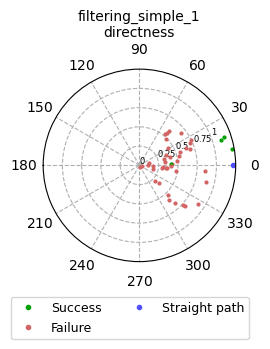

In [116]:
# Plot directness on polar plot (ACTUAL)
# Initialize figure
fig = plt.figure(figsize=(2.5,2.5))
ax = fig.add_subplot(111, projection='polar')

# Plot directness
i = 0
for index, row in resultsFiltered.iterrows():
    # Get directness
    directness = row['directness']

    # Plot directness
    # If successful
    if row['outcome'] == 1:
        ax.plot(directness[1], directness[0], 'o', 
                color=[0/255,160/255,0/255], markersize=2)
    else:
        ax.plot(directness[1], directness[0], 'o', 
                color=[210/255,100/255,100/255], markersize=2)

    i += 1 

# Custom legend
custom_lines = [Line2D([0], [0], marker='o', color=np.array([0,160,0])/255, 
                       lw=0, markersize=3),
                Line2D([0], [0], marker='o', color=np.array([210,100,100])/255, 
                       lw=0, markersize=3),
                Line2D([0], [0], marker='o', color=np.array([80,80,255])/255, 
                       lw=0, markersize=3)]
plt.legend(custom_lines, ['Success', 'Failure', 'Straight path'], 
           loc='upper left', bbox_to_anchor=(-0.2, -0.15), ncol=2, fontsize=9)

# Set axis limits
ax.set_ylim(0, 1)
ax.set_xlim(-np.pi, np.pi)

# Plot ideal straight line
ax.plot(0,0.975,'o', color=[80/255,80/255,255/255], markersize=3)

# Set axis labels with degrees and zero at right side
ax.set_theta_zero_location('E')

# Set axis labels
ax.set_xticklabels([r'$180$', r'$210$', r'$240$', r'$270$', r'$300$', 
                    r'$330$', r'$0$', r'$30$', r'$60$', r'$90$', 
                    r'$120$', r'$150$'])

# Set axis ticks
ax.set_xticks(np.linspace(-np.pi, np.pi, 12, endpoint=False))

# Set axis labels
ax.set_yticklabels(['0', r'$0.25$', r'$0.5$', r'$0.75$', r'$1$'], fontsize=6)

# Set axis ticks
ax.set_yticks(np.linspace(0, 1, 5, endpoint=False))

# Set grid with dashed lines
ax.grid(True, linestyle='--')

# Set title
ax.set_title(f'{runName}\ndirectness', y=1.125, fontsize=10)

# Show plot
plt.show()

C:\Users\hansv\AppData\Local\Temp\ipykernel_11132\1739679620.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$180$', r'$210$', r'$240$', r'$270$', r'$300$',
C:\Users\hansv\AppData\Local\Temp\ipykernel_11132\1739679620.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', r'$0.25$', r'$0.5$', r'$0.75$', r'$1$'], fontsize=6)


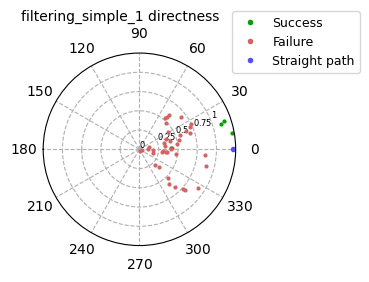

In [130]:
# Plot directness on polar plot (EXAMPLE)
# Initialize figure
fig = plt.figure(figsize=(2.5,2.5))
ax = fig.add_subplot(111, projection='polar')

# Plot directness
i = 0
for index, row in resultsFiltered.iterrows():
    # Get directness
    directness = row['directness']

    # Plot directness
    # If successful
    if row['outcome'] == 1:
        ax.plot(directness[1], directness[0], 'o', 
                color=[0/255,160/255,0/255], markersize=2)
    else:
        ax.plot(directness[1], directness[0], 'o', 
                color=[210/255,100/255,100/255], markersize=2)

    i += 1 

# Custom legend
custom_lines = [Line2D([0], [0], marker='o', color=np.array([0,160,0])/255, 
                       lw=0, markersize=3),
                Line2D([0], [0], marker='o', color=np.array([210,100,100])/255, 
                       lw=0, markersize=3),
                Line2D([0], [0], marker='o', color=np.array([80,80,255])/255, 
                       lw=0, markersize=3)]
plt.legend(custom_lines, ['Success', 'Failure', 'Straight path'], 
           loc='upper left', bbox_to_anchor=(0.95,1.25), ncol=1, fontsize=9)

# Set axis limits
ax.set_ylim(0, 1)
ax.set_xlim(-np.pi, np.pi)

# Plot ideal straight line
ax.plot(0,0.975,'o', color=[80/255,80/255,255/255], markersize=3)

# Set axis labels with degrees and zero at right side
ax.set_theta_zero_location('E')

# Set axis labels
ax.set_xticklabels([r'$180$', r'$210$', r'$240$', r'$270$', r'$300$', 
                    r'$330$', r'$0$', r'$30$', r'$60$', r'$90$', 
                    r'$120$', r'$150$'])

# Set axis ticks
ax.set_xticks(np.linspace(-np.pi, np.pi, 12, endpoint=False))

# Set axis labels
ax.set_yticklabels(['0', r'$0.25$', r'$0.5$', r'$0.75$', r'$1$'], fontsize=6)

# Set axis ticks
ax.set_yticks(np.linspace(0, 1, 5, endpoint=False))

# Set grid with dashed lines
ax.grid(True, linestyle='--')

# Set title
ax.set_title(f'{runName} directness', x=0.4,y=1.125, fontsize=10)

# Show plot
plt.show()

In [13]:
resultsFiltered.groupby('position')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
position,,,,,,,,
0,5.0,50.378526,11.140712,41.285729,44.408399,46.889352,49.808864,69.500285
1,5.0,58.802404,28.218330,41.650138,42.958739,48.614073,52.078180,108.710893
2,5.0,65.827998,21.463806,43.552116,44.253509,68.565147,82.611945,90.157271
3,5.0,61.001504,20.338608,46.015790,47.048999,48.280660,71.686258,91.975817
4,5.0,60.887348,30.412959,43.637084,45.462716,49.000949,51.307675,115.028319
5,5.0,81.058605,48.652980,42.522048,51.116474,56.821307,94.240710,160.592483
6,5.0,52.075600,6.333395,46.018839,47.467272,51.807177,52.922637,62.162077
7,5.0,83.625526,46.701565,41.430528,46.137382,64.139140,122.225094,144.195486
8,5.0,58.714279,29.918680,43.937905,44.342166,45.159958,47.971086,112.160280


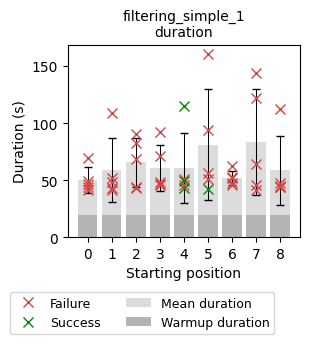

In [101]:
# Plot total duration (ACTUAL)
# Initialize figure
fig = plt.figure(figsize=(3,2.5))
ax = fig.add_subplot(111)

# Get mean and std of duration for all positions
durationMean = resultsFiltered.groupby('position')['duration'].mean()
durationStd = resultsFiltered.groupby('position')['duration'].std()
# print(durationStd)
# Plot duration in a bar chart of positions with error bars
ax.bar(range(0,9), durationMean, yerr=durationStd, 
       ecolor='black', alpha=1, align='center', capsize=3, 
       color=[220/255,220/255,220/255], error_kw={'elinewidth': 0.75})

# # Plot uniform bar chart of warmup time on all positions
ax.bar(range(0,9), np.ones(9)*20, color=[180/255,180/255,180/255], 
       alpha=1, align='center')

# Plot single set of duration points per outcome for legend
sIdx = 0
sBreak = False
fIdx = 0
fBreak = False
for index, row in resultsFiltered.iterrows():
    if sBreak and fBreak:
        break
    elif row['outcome'] == 1 and sIdx == 0 and not sBreak: # If success
        ax.plot(row['position'], row['duration'], 
                'x', color=[0/255,140/255,0/255], markersize=7,linewidth=0.5)
        sIdx = index
        sBreak = True
    elif not fBreak:
        ax.plot(row['position'], row['duration'], 
                'x', color=[210/255,70/255,70/255], markersize=7,linewidth=0.5)
        fIdx = index
        fBreak = True

# Show legend 
if sIdx < fIdx:
    ax.legend(['Success', 'Failure', 'Mean duration', 'Warmup duration'], 
              loc='upper left', ncol=2, bbox_to_anchor=(-0.275, -0.25), 
              fontsize=9)
else:
    ax.legend(['Failure', 'Success', 'Mean duration', 'Warmup duration'], 
              loc='upper left', ncol=2, bbox_to_anchor=(-0.275, -0.25), 
              fontsize=9)

# Plot rest of individual duration points based on outcome

for index, row in resultsFiltered.iterrows():
    if sIdx == index or fIdx == index:
        continue
    elif row['outcome'] == 1: # If success
        ax.plot(row['position'], row['duration'], 
                'x', color=[0/255,140/255,0/255], markersize=7,linewidth=0.5)
    else:
        ax.plot(row['position'], row['duration'], 
                'x', color=[210/255,70/255,70/255], markersize=7,linewidth=0.5)

# Set ticks
ax.set_xticks(range(0,9))

# Set axis labels
ax.set_xlabel('Starting position')
ax.set_ylabel('Duration (s)')
ax.set_title(f'{runName}\nduration', y=1, fontsize=10)

# Show plot
plt.show()

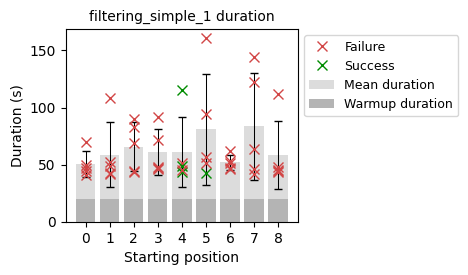

In [105]:
# Plot total duration (EXAMPLE)
# Initialize figure
fig = plt.figure(figsize=(3,2.5))
ax = fig.add_subplot(111)

# Get mean and std of duration for all positions
durationMean = resultsFiltered.groupby('position')['duration'].mean()
durationStd = resultsFiltered.groupby('position')['duration'].std()
# print(durationStd)
# Plot duration in a bar chart of positions with error bars
ax.bar(range(0,9), durationMean, yerr=durationStd, 
       ecolor='black', alpha=1, align='center', capsize=3, 
       color=[220/255,220/255,220/255], error_kw={'elinewidth': 0.75})

# # Plot uniform bar chart of warmup time on all positions
ax.bar(range(0,9), np.ones(9)*20, color=[180/255,180/255,180/255], 
       alpha=1, align='center')

# Plot single set of duration points per outcome for legend
sIdx = 0
sBreak = False
fIdx = 0
fBreak = False
for index, row in resultsFiltered.iterrows():
    if sBreak and fBreak:
        break
    elif row['outcome'] == 1 and sIdx == 0 and not sBreak: # If success
        ax.plot(row['position'], row['duration'], 
                'x', color=[0/255,140/255,0/255], markersize=7,linewidth=0.5)
        sIdx = index
        sBreak = True
    elif not fBreak:
        ax.plot(row['position'], row['duration'], 
                'x', color=[210/255,70/255,70/255], markersize=7,linewidth=0.5)
        fIdx = index
        fBreak = True

# Show legend 
if sIdx < fIdx:
    ax.legend(['Success', 'Failure', 'Mean duration', 'Warmup duration'], 
              loc='upper left', ncol=1, bbox_to_anchor=(1, 1), 
              fontsize=9)
else:
    ax.legend(['Failure', 'Success', 'Mean duration', 'Warmup duration'], 
              loc='upper left', ncol=1, bbox_to_anchor=(1, 1), 
              fontsize=9)

# Plot rest of individual duration points based on outcome

for index, row in resultsFiltered.iterrows():
    if sIdx == index or fIdx == index:
        continue
    elif row['outcome'] == 1: # If success
        ax.plot(row['position'], row['duration'], 
                'x', color=[0/255,140/255,0/255], markersize=7,linewidth=0.5)
    else:
        ax.plot(row['position'], row['duration'], 
                'x', color=[210/255,70/255,70/255], markersize=7,linewidth=0.5)

# Set ticks
ax.set_xticks(range(0,9))

# Set axis labels
ax.set_xlabel('Starting position')
ax.set_ylabel('Duration (s)')
ax.set_title(f'{runName} duration', y=1, fontsize=10)

# Show plot
plt.show()

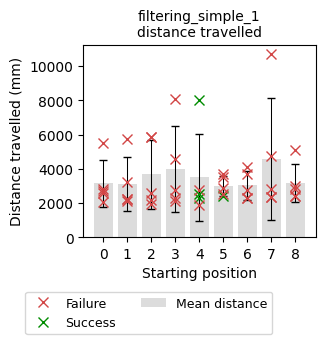

In [102]:
# Plot total distance travelled (ACTUAL)
# Initialize figure
fig = plt.figure(figsize=(3,2.5))
ax = fig.add_subplot(111)

# Get mean and std of distance travelled for all positions
distanceTravelledMean = resultsFiltered.groupby('position')[
                            'distanceTravelled'].mean()
distanceTravelledStd = resultsFiltered.groupby('position')[
                            'distanceTravelled'].std()

# Plot distance travelled in a bar chart of positions with error bars
ax.bar(range(0,9), distanceTravelledMean, yerr=distanceTravelledStd, 
       ecolor='black', alpha=1, align='center', capsize=3, 
       color=[220/255,220/255,220/255], error_kw={'elinewidth': 0.75})

# Plot single set of duration points per outcome for legend
sIdx = 0
sBreak = False
fIdx = 0
fBreak = False
for index, row in resultsFiltered.iterrows():
    if sBreak and fBreak:
        break
    elif row['outcome'] == 1 and sIdx == 0 and not sBreak: # If success
        ax.plot(row['position'], row['distanceTravelled'], 
                'x', color=[0/255,140/255,0/255], markersize=7,linewidth=0.5)
        sIdx = index
        sBreak = True
    elif not fBreak:
        ax.plot(row['position'], row['distanceTravelled'], 
                'x', color=[210/255,70/255,70/255], markersize=7,linewidth=0.5)
        fIdx = index
        fBreak = True

# Sort legend label
if sIdx < fIdx:
    ax.legend(['Success', 'Failure', 'Mean distance'], loc='upper left', 
              ncol=2, bbox_to_anchor=(-0.275, -0.25), 
              fontsize=9)
else:
    ax.legend(['Failure', 'Success', 'Mean distance'], loc='upper left', 
              ncol=2, bbox_to_anchor=(-0.275, -0.25), 
              fontsize=9)

# Plot rest of individual distance points based on outcome
for index, row in resultsFiltered.iterrows():
    if sIdx == index or fIdx == index:
        continue
    elif row['outcome'] == 1: # If success
        ax.plot(row['position'], row['distanceTravelled'], 
                'x', color=[0/255,140/255,0/255], markersize=7,linewidth=0.5)
    else:
        ax.plot(row['position'], row['distanceTravelled'], 
                'x', color=[210/255,70/255,70/255], markersize=7,linewidth=0.5)

# Plot individual duration points based on outcome
# for index, row in resultsFiltered.iterrows():
#     if row['outcome'] == 1: # If success
#         ax.plot(row['position'], row['distanceTravelled'], 'o', color=[0/255,160/255,0/255], markersize=3)
#     else:
#         ax.plot(row['position'], row['distanceTravelled'], 'o', color=[210/255,60/255,60/255], markersize=3)
# ax.plot(resultsFiltered['position'], resultsFiltered['distanceTravelled'], 'o', color='black', markersize=3)

# Set ticks
ax.set_xticks(range(0,9))

# Set axis labels
ax.set_xlabel('Starting position')
ax.set_ylabel('Distance travelled (mm)')
ax.set_title(f'{runName}\ndistance travelled', y=1, fontsize=10)

# Show plot
plt.show()

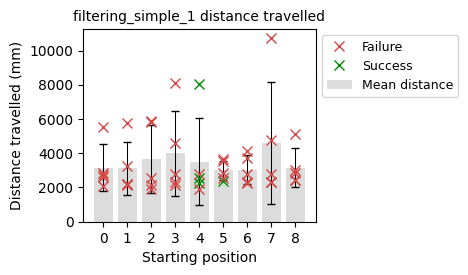

In [104]:
# Plot total distance travelled (EXAMPLE)
# Initialize figure
fig = plt.figure(figsize=(3,2.5))
ax = fig.add_subplot(111)

# Get mean and std of distance travelled for all positions
distanceTravelledMean = resultsFiltered.groupby('position')[
                            'distanceTravelled'].mean()
distanceTravelledStd = resultsFiltered.groupby('position')[
                            'distanceTravelled'].std()

# Plot distance travelled in a bar chart of positions with error bars
ax.bar(range(0,9), distanceTravelledMean, yerr=distanceTravelledStd, 
       ecolor='black', alpha=1, align='center', capsize=3, 
       color=[220/255,220/255,220/255], error_kw={'elinewidth': 0.75})

# Plot single set of duration points per outcome for legend
sIdx = 0
sBreak = False
fIdx = 0
fBreak = False
for index, row in resultsFiltered.iterrows():
    if sBreak and fBreak:
        break
    elif row['outcome'] == 1 and sIdx == 0 and not sBreak: # If success
        ax.plot(row['position'], row['distanceTravelled'], 
                'x', color=[0/255,140/255,0/255], markersize=7,linewidth=0.5)
        sIdx = index
        sBreak = True
    elif not fBreak:
        ax.plot(row['position'], row['distanceTravelled'], 
                'x', color=[210/255,70/255,70/255], markersize=7,linewidth=0.5)
        fIdx = index
        fBreak = True

# Sort legend label
if sIdx < fIdx:
    ax.legend(['Success', 'Failure', 'Mean distance'], loc='upper left', 
              ncol=1, bbox_to_anchor=(1, 1), 
              fontsize=9)
else:
    ax.legend(['Failure', 'Success', 'Mean distance'], loc='upper left', 
              ncol=1, bbox_to_anchor=(1,1), 
              fontsize=9)

# Plot rest of individual distance points based on outcome
for index, row in resultsFiltered.iterrows():
    if sIdx == index or fIdx == index:
        continue
    elif row['outcome'] == 1: # If success
        ax.plot(row['position'], row['distanceTravelled'], 
                'x', color=[0/255,140/255,0/255], markersize=7,linewidth=0.5)
    else:
        ax.plot(row['position'], row['distanceTravelled'], 
                'x', color=[210/255,70/255,70/255], markersize=7,linewidth=0.5)

# Plot individual duration points based on outcome
# for index, row in resultsFiltered.iterrows():
#     if row['outcome'] == 1: # If success
#         ax.plot(row['position'], row['distanceTravelled'], 'o', color=[0/255,160/255,0/255], markersize=3)
#     else:
#         ax.plot(row['position'], row['distanceTravelled'], 'o', color=[210/255,60/255,60/255], markersize=3)
# ax.plot(resultsFiltered['position'], resultsFiltered['distanceTravelled'], 'o', color='black', markersize=3)

# Set ticks
ax.set_xticks(range(0,9))

# Set axis labels
ax.set_xlabel('Starting position')
ax.set_ylabel('Distance travelled (mm)')
ax.set_title(f'{runName} distance travelled', y=1, fontsize=10)

# Show plot
plt.show()

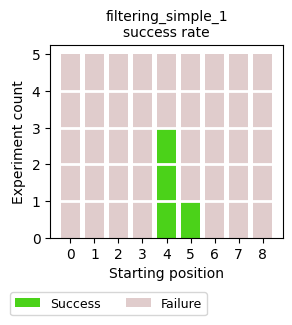

In [109]:
# Plot success rate (ACTUAL)
# Initialize figure
fig = plt.figure(figsize=(3,2.5))
ax = fig.add_subplot(111)

# Plot stack bar chart of success and failure
ax.bar(range(0,9), resultsFiltered.groupby('position')['outcome'].sum(), 
       color=[75/255,210/255,25/255], alpha = 1.0, align='center')
ax.bar(range(0,9), 5 - resultsFiltered.groupby('position')['outcome'].sum(), 
       bottom=resultsFiltered.groupby('position')['outcome'].sum(), 
       color=[100/255,0/255,0/255], alpha = 0.2,align='center')

# Get legend
ax.legend(['Success', 'Failure'], loc='upper left', 
          ncol=2, bbox_to_anchor=(-0.2, -0.25), fontsize=9)

# Draw horizontal white lines to separate units
for i in range(1,5):
    ax.axhline(i, color='white', linewidth=2)

# Set ticks
ax.set_xticks(range(0,9))

# Set axis labels
ax.set_xlabel('Starting position')
ax.set_ylabel('Experiment count')
ax.set_title(f'{runName}\nsuccess rate', y=1, fontsize=10)

# Show plot
plt.show()

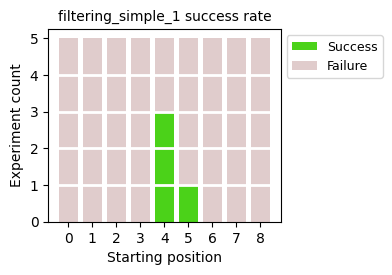

In [111]:
# Plot success rate (EXAMPLE)
# Initialize figure
fig = plt.figure(figsize=(3,2.5))
ax = fig.add_subplot(111)

# Plot stack bar chart of success and failure
ax.bar(range(0,9), resultsFiltered.groupby('position')['outcome'].sum(), 
       color=[75/255,210/255,25/255], alpha = 1.0, align='center')
ax.bar(range(0,9), 5 - resultsFiltered.groupby('position')['outcome'].sum(), 
       bottom=resultsFiltered.groupby('position')['outcome'].sum(), 
       color=[100/255,0/255,0/255], alpha = 0.2,align='center')

# Get legend
ax.legend(['Success', 'Failure'], loc='upper left', 
          ncol=1, bbox_to_anchor=(1,1), fontsize=9)

# Draw horizontal white lines to separate units
for i in range(1,5):
    ax.axhline(i, color='white', linewidth=2)

# Set ticks
ax.set_xticks(range(0,9))

# Set axis labels
ax.set_xlabel('Starting position')
ax.set_ylabel('Experiment count')
ax.set_title(f'{runName} success rate', y=1, fontsize=10)

# Show plot
plt.show()

In [48]:
resultsFiltered.iloc[0]

dateTime                                               2023-05-11 15:04:22
experimentName                                    filtering_simple_1_p0_i0
duration                                                         49.808864
lastCoord                         (1872.8243995904922, 1772.5343990325928)
lastHeading                                                     -28.859356
outcome                                                                  0
position                                                                 0
iteration                                                                0
logTime                  [19.87985710000794, 20.007923299999675, 20.139...
logCoord                 [[718.3515621572733, -283.4324297904968], [717...
logHeading               [-94.0105188303804, -94.0510833238611, -93.726...
logHeadingRelative       [-59.82093843916998, -60.06672789176224, -60.0...
distanceTravelled                                              2710.647652
spacedCoord              

In [45]:
resultsFiltered

,dateTime,experimentName,duration,lastCoord,lastHeading,outcome,position,iteration,logTime,logCoord,logHeading,logHeadingRelative,distanceTravelled,spacedCoord,spacedHeading,spacedHeadingRelative,directness
65,2023-05-11 15:04:22,filtering_simple_1_p0_i0,49.808864,"(1872.8243995904922, 1772.5343990325928)",-28.859356,0,0,0,"[19.87985710000794, 20.007923299999675, 20.139...","[[718.3515621572733, -283.4324297904968], [717...","[-94.0105188303804, -94.0510833238611, -93.726...","[-59.82093843916998, -60.06672789176224, -60.0...",2710.647652,"[[718.3515621572733, -283.4324297904968], [711...","[-94.0105188303804, -92.866612408565, -91.8151...","[-59.82093843916998, -61.64655929529731, -64.2...","[0.4703363005281227, -0.8595982016435514]"
74,2023-05-11 15:19:29,filtering_simple_1_p0_i1,46.889352,"(628.2872452139854, 222.72953498363495)",74.399570,0,0,1,"[19.96894439999596, 20.10774879998644, 20.2407...","[[716.1483688689768, -248.89417350292206], [71...","[-91.6803929648414, -92.30166014155655, -93.11...","[-58.24291041167655, -59.14607895296866, -60.2...",2840.243293,"[[716.1483688689768, -248.89417350292206], [71...","[-91.6803929648414, -95.77007801341324, -97.97...","[-58.24291041167655, -65.47950501192054, -71.3...","[0.025731859035677547, -0.10203582762773214]"
83,2023-05-11 15:36:17,filtering_simple_1_p0_i2,69.500285,"(1568.3495746850967, 1770.3458417323418)",179.818090,0,0,2,"[19.87741899999673, 20.026287100001355, 20.174...","[[717.6695175543427, -285.6799943447113], [718...","[-93.22624918912284, -93.13122759738964, -93.0...","[-58.9997431168241, -59.22908189174294, -59.39...",5534.185700,"[[717.6695175543427, -285.6799943447113], [712...","[-93.22624918912284, -93.3537005190353, -93.73...","[-58.9997431168241, -62.33700988635616, -66.58...","[0.1445825949326407, -0.2805707010318987]"
93,2023-05-11 15:56:40,filtering_simple_1_p0_i3,41.285729,"(1340.621938586235, 220.00035309791565)",73.146702,0,0,3,"[19.96917799999937, 20.108782399998745, 20.253...","[[718.649508446455, -252.066241979599], [717.7...","[-94.9954184483179, -95.91328658974088, -96.34...","[-61.45635938854226, -62.78784166508472, -63.5...",2592.886428,"[[718.649508446455, -252.066241979599], [706.4...","[-94.9954184483179, -99.42482344582784, -100.9...","[-61.45635938854226, -69.52661766675514, -75.1...","[0.24846148822517053, -0.06037486537044142]"
102,2023-05-11 16:15:54,filtering_simple_1_p0_i4,44.408399,"(558.1066937148571, 1776.605964422226)",-83.815205,0,0,4,"[19.85100809999858, 20.02157270000316, 20.1791...","[[716.1702106483281, -288.476545214653], [717....","[-91.76501217846868, -91.35038554490303, -91.9...","[-57.501799324036675, -57.21058673272492, -58....",2084.239868,"[[716.1702106483281, -288.476545214653], [714....","[-91.76501217846868, -94.43063010584954, -96.5...","[-57.501799324036675, -63.38779144270082, -69....","[0.01738701574216799, -0.9746618325751841]"
67,2023-05-11 15:07:41,filtering_simple_1_p1_i0,42.958739,"(825.916598200798, 1775.8424643278122)",-144.338672,0,1,0,"[19.875312300006044, 20.02123319999373, 20.158...","[[212.38148480653763, -176.7275003194809], [21...","[-67.48657201890309, -66.95461639577499, -66.1...","[-41.30978342460789, -40.99539197158687, -40.3...",2226.340967,"[[212.38148480653763, -176.7275003194809], [26...","[-67.48657201890309, -60.94236969962794, -57.4...","[-41.30978342460789, -36.837725209667525, -35....","[0.2724646771917256, -0.7286386728805718]"
76,2023-05-11 15:23:16,filtering_simple_1_p1_i1,108.710893,"(1455.0433817356825, 349.9340754747391)",-93.062939,0,1,1,"[19.96618689999741, 20.097976899996866, 20.238...","[[212.840385556221, -168.80345106124878], [220...","[-69.67079821358146, -69.26912161868219, -69.4...","[-43.64232427684719, -43.44020344426361, -43.8...",5760.982731,"[[212.840385556221, -168.80345106124878], [270...","[-69.67079821358146, -70.29961957951869, -71.0...","[-43.64232427684719, -46.54507397630496, -49.8...","[0.2378258252434206, -0.13523639062472353]"
85,2023-05-11 15:40:35,fil